# Project Loading Example

_This notebook uses a dataset of videos stored as a tensor flow datasets._

## Setup

First, let's make sure we have the proper version installed. This notebook works in python 3. Import a few common modules.

In [1]:
from pkg_resources import parse_version

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3,5) 

# Tensorflow ≥2.0 is required

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_seed(seed=42):
    np.random.seed(seed)

# To plot pretty figures - source Aurelien Geron
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# Based on post by GM at https://stackoverflow.com/questions/53581278
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  # mount your google drive into colab
  # this is interactive unfortunately
  # must paste authorization code on prompt
  drive.mount('/content/drive') 
  PROJECT_ROOT_DIR = "drive/MyDrive/Colab Notebooks"
else:
  print('Not running on CoLab')
  PROJECT_ROOT_DIR = os.getcwd()

NB_ID = "project"

# create the directory if it does not exist
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "images", NB_ID)
os.makedirs(IMAGE_DIR, exist_ok = True)
        
def save_fig_nb(fig_id, tight_layout=True):
    path = os.path.join(IMAGE_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
os.makedirs(os.path.join(PROJECT_ROOT_DIR,"tb_logs",NB_ID), exist_ok = True)

def get_logdir(add=''):
    import time
    log_id = time.strftime("log_%Y_%m_%d-%H_%M_%S")
    return os.path.join(PROJECT_ROOT_DIR,"tb_logs",NB_ID,log_id+add)

Not running on CoLab


A couple utility functions to plot grayscale and RGB images (source Aurelien Geron):

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

## Import tfds and other libraries

In [3]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds

# For some reason we seem to need to load tf onto the GPU first
dummy = tf.constant( 32 )
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading

The dataset is packaged as a Tensorflow dataset in three sub categories.


In [4]:
tfds.disable_progress_bar()

print(PROJECT_ROOT_DIR)

data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
os.makedirs(data_path, exist_ok = True)

print("Using directory: ", data_path)

# flow_data_set = tfds.load('elg7186_projectdata/linear_movement_rotate')
# flow_data_set = tfds.load('elg7186_projectdata/rotation_rotate')
flow_data_set = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

# Set up an iterator over the data
iter_data = iter(flow_data_set['train'])
# Get the first video
train_data = next(iter_data)

d:\OneDrive - University of Ottawa\Drive\ELG7186\2023\assignments\project\tensorflow
Using directory:  d:\OneDrive - University of Ottawa\Drive\ELG7186\2023\assignments\project\tensorflow\tensorflow_data


## Explore the Data
Let's look at the data_records themselves.

Data has format: <class 'dict'>
dict_keys(['background', 'backward_flow', 'camera', 'depth', 'events', 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates', 'segmentations', 'video'])
dict_keys(['backward_flow_range', 'depth_range', 'forward_flow_range', 'height', 'num_frames', 'num_instances', 'video_name', 'video_type', 'width'])
dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 'bboxes_3d', 'category', 'friction', 'image_positions', 'mass', 'positions', 'quaternions', 'restitution', 'scale', 'velocities', 'visibility'])
tf.Tensor([13  6 16 13 10 14  3], shape=(7,), dtype=int64)
(24, 256, 256, 1)
tf.Tensor(
[b'Ecoforms_Plant_Saucer_S14NATURAL' b'Footed_Bowl_Sand'
 b'FRACTION_FUN_n4h4qte23QR' b'Nordic_Ware_Original_Bundt_Pan'
 b'Android_Lego' b'Womens_Bluefish_2Eye_Boat_Shoe_in_Tan'
 b'Threshold_Porcelain_Spoon_Rest_White'], shape=(7,), dtype=string)
0
7


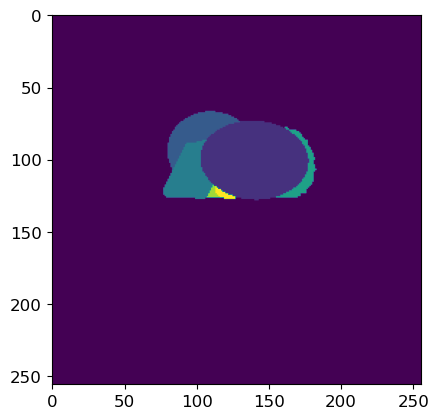

In [5]:
# the type is a subclass of tf.data.Dataset
print('Data has format: {0}'.format(type(train_data)))

# Result is one training movie with the following
print(dict.keys(train_data))
# dict_keys(['background', 'backward_flow', 'camera', 'depth', 'events',
# 'forward_flow', 'instances', 'metadata', 'normal', 'object_coordinates',
# 'segmentations', 'video'])
# These are returned as EagerTensor
# The metadata contains
print(dict.keys(train_data['metadata']))
# dict_keys(['backward_flow_range', 'depth_range', 'forward_flow_range',
# 'height', 'num_frames', 'num_instances', 'video_name', 'width'])
print(dict.keys(train_data['instances']))
# dict_keys(['angular_velocities', 'asset_id', 'bbox_frames', 'bboxes', 
# 'bboxes_3d', 'category', 'friction', 'image_positions', 'mass', 
# 'positions', 'quaternions', 'restitution', 'scale', 'velocities', 'visibility'])

print(train_data['instances']['category'])
print(train_data['segmentations'].shape)
print(train_data['instances']['asset_id'])
seg = train_data['segmentations'][0,:,:,:].numpy()
print( np.min(seg) )
print( np.max(seg) )
plt.imshow(train_data['segmentations'][0, :, :, :])

## Let's look at optical flow data as an example

Video:  0003
Video type:  fixed_random_rotate_007
forward_flow range -16.59033203125 to 16.885251998901367
Saving figure 0003_flow


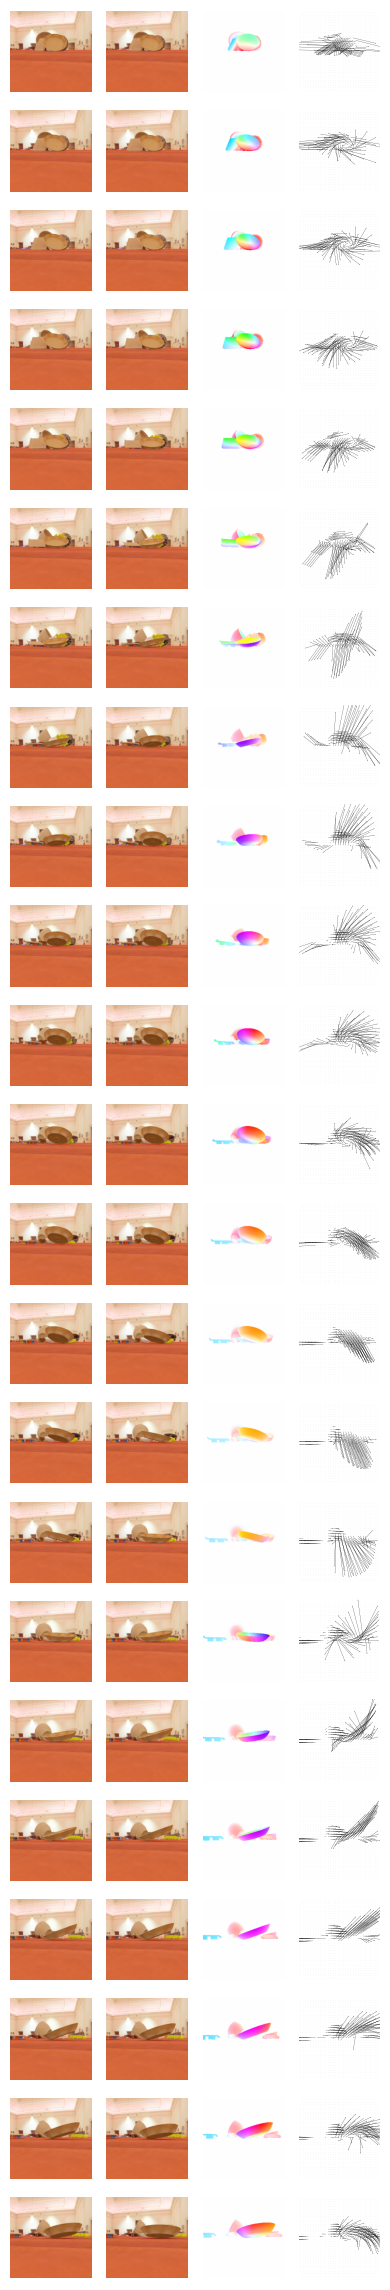

In [6]:
import numpy as np
# flow_vis library implements Middlebury flow vector coloring
import flow_vis
# Maybe use flowpy instead which can read/write png and flo files in KITTI and Middleburry format respectively.
from flow_util import * 

video_name, video_type = get_video_names( train_data['metadata'] )
f_scale, f_offset = get_scale_offset( train_data['metadata'] )

num_frames = int(train_data['metadata']['num_frames'])
x_mesh = np.empty(1)
y_mesh = np.empty(1)        
    
n_cols = 4
figId = plt.figure(figsize=(n_cols, num_frames))

plt.subplots_adjust(wspace=0, hspace=0)

for i in range(num_frames-1):
    img_cnt = i*n_cols
    _ = plt.subplot(num_frames, n_cols, img_cnt+1)
    plt.imshow(train_data['video'][i, :, :, :])
    plt.axis("off")
    _ = plt.subplot(num_frames, n_cols, img_cnt+2)
    plt.imshow(train_data['video'][i+1, :, :, :])
    plt.axis("off")

    _ = plt.subplot(num_frames, n_cols, img_cnt+3)
    forward_flow = train_data['forward_flow'][i, :, :, :].numpy()
    forward_flow = f_scale * forward_flow + f_offset
    forward_flow = forward_flow 
    # flip row and column as train_data is row,col but flow_vis expects column,row
    forward_flow_vis = np.stack([forward_flow[:,:,1],forward_flow[:,:,0]], axis=-1)
    flow_color = flow_vis.flow_to_image(forward_flow_vis,
                                        convert_to_bgr=False)
    plt.imshow(flow_color)
    plt.axis("off")
    ax = plt.subplot(num_frames, n_cols, img_cnt+4)
    _, x_mesh, y_mesh = flow_quiver( ax, forward_flow, x_mesh, y_mesh )
    plt.axis("equal")
    plt.axis("off")

save_video_fig(figId, video_name + '_flow', video_type, IMAGE_DIR)

## Let's look at Object Coordinates as an example

Video:  0003
Video type:  fixed_random_rotate_007
forward_flow range -16.59033203125 to 16.885251998901367
resolution: [<tf.Tensor: shape=(), dtype=int32, numpy=256>, <tf.Tensor: shape=(), dtype=int32, numpy=256>]


Saving figure 0003_objects


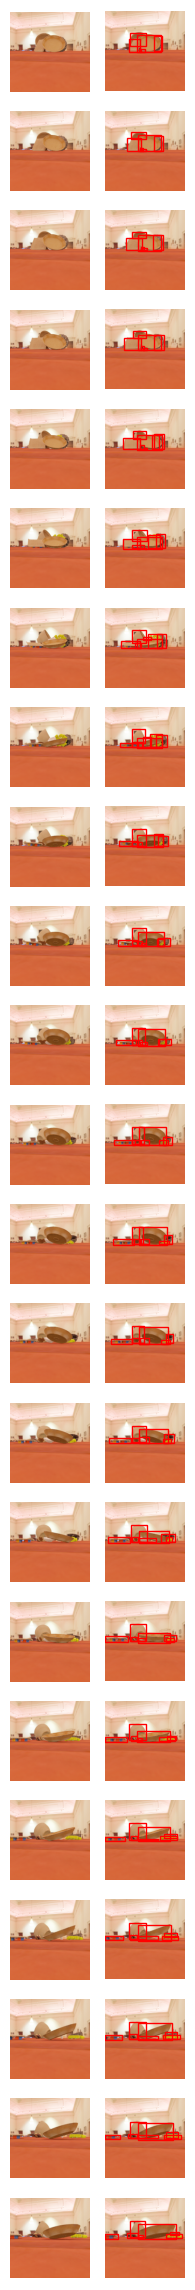

In [7]:
import numpy as np
# flow_vis library implements Middlebury flow vector coloring
import flow_vis
# Maybe use flowpy instead which can read/write png and flo files in KITTI and Middleburry format respectively.
from flow_util import * 
import matplotlib.patches as patches

def find_index(input, id):
    for i in range(len(input)):
        if input[i] == id:
            return i
            break  

video_name, video_type = get_video_names( train_data['metadata'] )
f_scale, f_offset = get_scale_offset( train_data['metadata'] )

num_frames = int(train_data['metadata']['num_frames'])
resolution = [train_data['metadata']['height'], train_data['metadata']['width']]

print('resolution:', resolution)
x_mesh = np.empty(1)
y_mesh = np.empty(1)        
    
n_cols = 3
figId = plt.figure(figsize=(n_cols, num_frames))

plt.subplots_adjust(wspace=0, hspace=0)

for i in range(num_frames-1):
    img_cnt = i*n_cols
    _ = plt.subplot(num_frames, n_cols, img_cnt+1)
    plt.imshow(train_data['video'][i, :, :, :])
    plt.axis("off")
    image = train_data['video'][i, :, :, :]
    ax2 = plt.subplot(num_frames, n_cols, img_cnt+2)
    segmentation = train_data['segmentations'][i, :, :, :].numpy()
    plt.imshow(image)
    for id in range(train_data['instances']['bbox_frames'].shape[0]):
        if i in train_data['instances']['bbox_frames'][id]:
            t = find_index(train_data['instances']['bbox_frames'][id],i)
            item = train_data['instances']['bboxes'][id,t,:]
            cls_id = train_data['instances']['category'][id]
            cls_name = train_data['instances']['asset_id'][id]
            y_min = int(item[0] * float(resolution[0]))
            x_min = int(item[1] * float(resolution[1]))
            y_max = int(item[2] * float(resolution[0]))
            x_max = int(item[3] * float(resolution[1]))
            # Create a Rectangle patch
            rect = patches.Rectangle((x_min, y_min), x_max - x_min  , y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax2.add_patch(rect)
        else:
            print("")    

    plt.axis("equal")
    plt.axis("off")
   
save_video_fig(figId, video_name + '_objects', video_type, IMAGE_DIR)

## Let's look at segmentation Map as an example

Video:  0003
Video type:  fixed_random_rotate_007
forward_flow range -16.59033203125 to 16.885251998901367
resolution: [<tf.Tensor: shape=(), dtype=int32, numpy=256>, <tf.Tensor: shape=(), dtype=int32, numpy=256>]
Saving figure 0003_seg


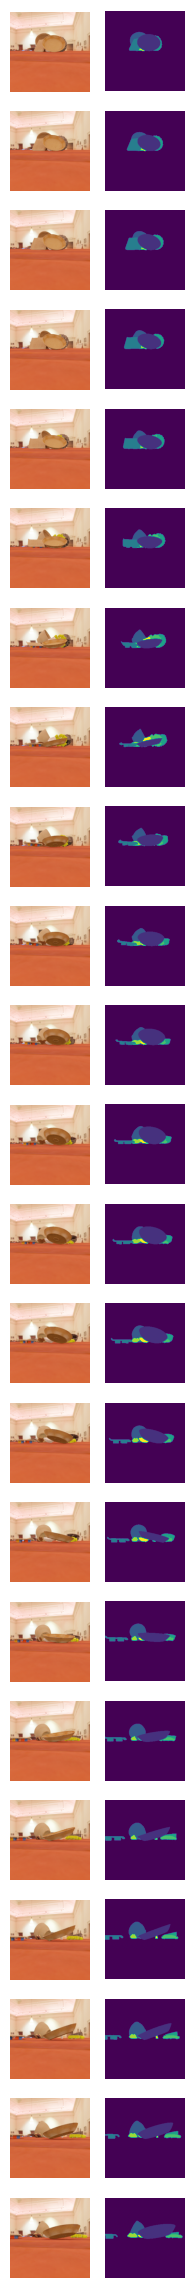

In [8]:
import numpy as np
# flow_vis library implements Middlebury flow vector coloring
import flow_vis
# Maybe use flowpy instead which can read/write png and flo files in KITTI and Middleburry format respectively.
from flow_util import * 
import matplotlib.patches as patches

video_name, video_type = get_video_names( train_data['metadata'] )
f_scale, f_offset = get_scale_offset( train_data['metadata'] )

num_frames = int(train_data['metadata']['num_frames'])
resolution = [train_data['metadata']['height'], train_data['metadata']['width']]

print('resolution:', resolution)
x_mesh = np.empty(1)
y_mesh = np.empty(1)        
    
n_cols = 3
figId = plt.figure(figsize=(n_cols, num_frames))

plt.subplots_adjust(wspace=0, hspace=0)

for i in range(num_frames-1):
    img_cnt = i*n_cols
    _ = plt.subplot(num_frames, n_cols, img_cnt+1)
    plt.imshow(train_data['video'][i, :, :, :])
    plt.axis("off")

    ax2 = plt.subplot(num_frames, n_cols, img_cnt+2)
    segmentation = train_data['segmentations'][i, :, :, :].numpy()
    plt.imshow(segmentation)
        
    plt.axis("off")
    plt.axis("equal")
    plt.axis("off")


save_video_fig(figId, video_name + '_seg', video_type, IMAGE_DIR)

## Let's look at Depth as an example

Video:  0003
Video type:  fixed_random_rotate_007
forward_flow range -16.59033203125 to 16.885251998901367
resolution: [<tf.Tensor: shape=(), dtype=int32, numpy=256>, <tf.Tensor: shape=(), dtype=int32, numpy=256>]
Saving figure 0003_depth


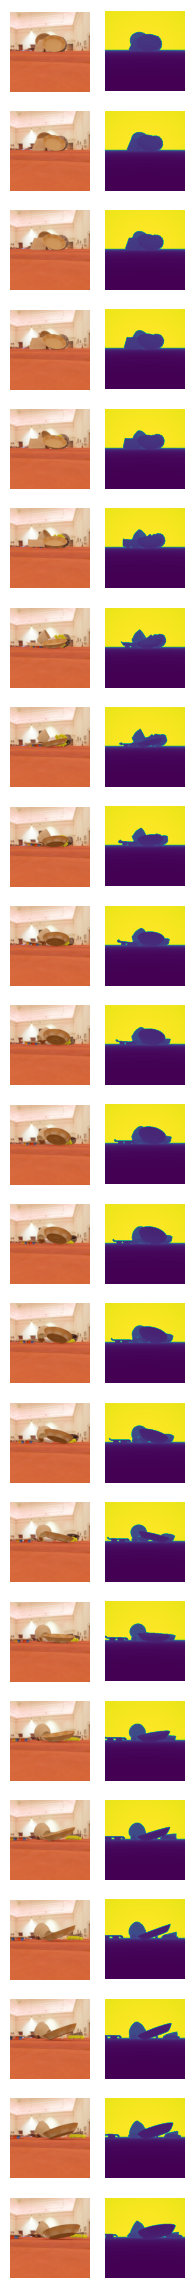

In [9]:
import numpy as np
# flow_vis library implements Middlebury flow vector coloring
import flow_vis
# Maybe use flowpy instead which can read/write png and flo files in KITTI and Middleburry format respectively.
from flow_util import * 
import matplotlib.patches as patches

video_name, video_type = get_video_names( train_data['metadata'] )
f_scale, f_offset = get_scale_offset( train_data['metadata'] )

num_frames = int(train_data['metadata']['num_frames'])
resolution = [train_data['metadata']['height'], train_data['metadata']['width']]

print('resolution:', resolution)
x_mesh = np.empty(1)
y_mesh = np.empty(1)        
    
n_cols = 3
figId = plt.figure(figsize=(n_cols, num_frames))

plt.subplots_adjust(wspace=0, hspace=0)

for i in range(num_frames-1):
    img_cnt = i*n_cols
    _ = plt.subplot(num_frames, n_cols, img_cnt+1)
    plt.imshow(train_data['video'][i, :, :, :])
    plt.axis("off")

    ax2 = plt.subplot(num_frames, n_cols, img_cnt+2)
    segmentation = train_data['depth'][i, :, :, :].numpy()
    plt.imshow(segmentation)
        
    plt.axis("off")
    plt.axis("equal")
    plt.axis("off")

save_video_fig(figId, video_name + '_depth', video_type, IMAGE_DIR)